In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import pandas as pd


Global seed set to 0


In [2]:
adata_mvi = sc.read_h5ad("data/datasets/SSC_multiome.h5ad")

In [9]:
adata_mvi

AnnData object with n_obs × n_vars = 4708 × 181316
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'Sample', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet', 'doublet_scores', 'Disease', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'seurat_clusters', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'Contamination', 'Cells', 'CellType', 'modality', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_new', 'leiden_v2', 'umap_density_Disease', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'palantir_pseudotime', 'palantir_entropy', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19', 'rna_latent_0', 'rna_latent_1', 'rna_latent

In [3]:


scvi.model.MULTIVI.setup_anndata(adata_mvi)

vae = scvi.model.MULTIVI(adata_mvi,
    n_genes=(adata_mvi.var['feature_types']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['feature_types']=='Peaks').sum())
# vae.train(batch_size=100)

In [4]:
vae.train(batch_size=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 221/500:  44%|████▍     | 221/500 [27:03<34:10,  7.35s/it, loss=9.56e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 20526.547. Signaling Trainer to stop.


In [5]:
vae.save("SSC_Multivi")

In [6]:
vae = vae.load("Neurips_Multivi", adata_mvi)

INFO     File Neurips_Multivi/model.pt already downloaded                                    


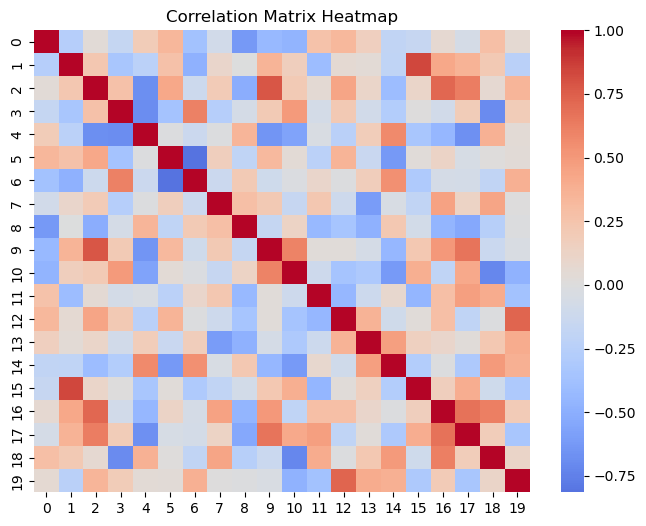

In [6]:
latent = vae.get_latent_representation()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_combined = pd.DataFrame(latent)
correlation_matrix = df_combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", center=0.0)
plt.title('Correlation Matrix Heatmap')
plt.show()

(array([0]), [Text(0, 0, 'multiVI')])

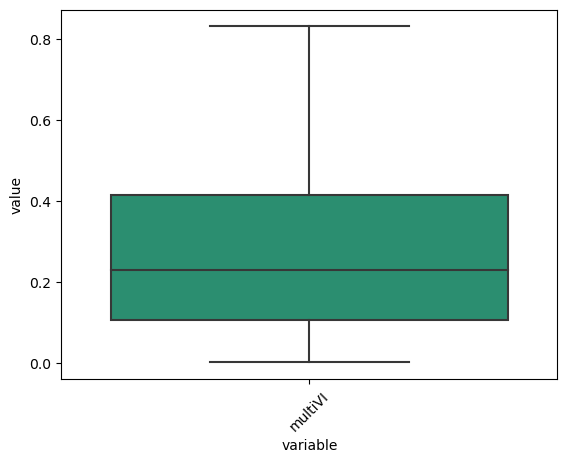

In [7]:
correlation_matrix = np.abs(correlation_matrix)
lower_triangular_matrix = np.tril(correlation_matrix, k=-1)
lower_diagonal_values = lower_triangular_matrix[lower_triangular_matrix != 0]
df = pd.DataFrame({"variable": "multiVI", "value": lower_diagonal_values})
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")
plt.xticks(rotation=45)

In [8]:
df.to_csv("figs/correlation_benchmark/SSC_corr_multiVI.csv")

In [6]:
latent = vae.get_latent_representation()
adata_mvi.obsm["X_mvi"] = latent

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


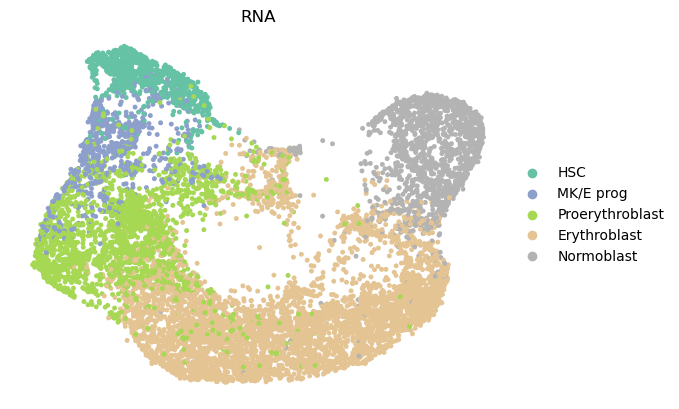

In [7]:
sc.pp.neighbors(adata_mvi, use_rep = 'X_mvi',n_neighbors=30, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.5, negative_sample_rate=0.1, spread=10)
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=['cell_type'], title="RNA",palette="Set2")

In [9]:
import scib

In [10]:
scib.metrics.graph_connectivity(adata_mvi, "cell_type")

0.9942810200303945

In [11]:
results = scib.metrics.silhouette_batch(adata_mvi, "batch",  "cell_type","X_mvi")


mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.856383
HSC                      0.785609
MK/E prog                0.855500
Normoblast               0.842582
Proerythroblast          0.837802


In [12]:
results

0.8355751484468323

In [13]:
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
batchlist= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()

In [14]:
from complementary_models import dHSIC

dHSIC(latent, batchlist)

0.009463345654958434

In [12]:
adata_mvi.var['feature_types'] = adata_mvi.var['feature_types'].cat.add_categories(["Gene Expression"])
adata_mvi.var.loc[adata_mvi.var.feature_types=="GEX","feature_types"] = "Gene Expression"

# adata_mvi.var[adata_mvi.var.feature_types=="GEX"].loc[:, "feature_types"] = "Gene Expression"

In [43]:
adata_mvi.var['feature_types'] = adata_mvi.var['feature_types'].cat.add_categories(["Peaks"])
adata_mvi.var.loc[adata_mvi.var.feature_types=="ATAC","feature_types"] = "Peaks"

In [44]:
from complementary_models import split_atac, split_rna


rnadata = split_rna(adata_mvi,  modality="feature_types")

In [45]:
rnadata

AnnData object with n_obs × n_vars = 10862 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch'
    var: 'feature_types', 'gene_id'

In [46]:
atacdata = split_atac(adata_mvi,  modality="feature_types")

In [47]:
atacdata

AnnData object with n_obs × n_vars = 10862 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch'
    var: 'feature_types', 'gene_id'

In [48]:
rnadata.write_h5ad("data/datasets/neurips_rna.h5ad")
atacdata.write_h5ad("data/datasets/neurips_atac.h5ad")


## MIRA

In [10]:
rnadata = sc.read_h5ad("/mnt/data0/halo/SSC/adata_RNA_MIRA.h5ad") 
atacdata = sc.read_h5ad("/mnt/data0/halo/SSC/adata_ATAC_MIRA_v1_norm.h5ad")


AnnData object with n_obs × n_vars = 4708 × 22129
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'Sample', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet', 'doublet_scores', 'Disease', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'seurat_clusters', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'Contamination', 'Cells', 'CellType', 'modality', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_new', 'leiden_v2', 'umap_density_Disease', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'palantir_pseudotime', 'palantir_entropy', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellType_colors', 'Cells_colors', 'DM_EigenValues', 'Sample_colors', '_scvi_manager_uuid', '_s

In [11]:
atacdata

AnnData object with n_obs × n_vars = 4708 × 178316
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'Sample', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet', 'doublet_scores', 'Disease', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'seurat_clusters', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'Contamination', 'Cells', 'CellType', 'modality', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_new', 'leiden_v2', 'umap_density_Disease', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'palantir_pseudotime', 'palantir_entropy', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'softmax_denom'
    var: 'gene_ids', 'feature_types', 'genome', 'endogenous_peaks', 'chr', 'start', 'end'
    uns: 'CellType_colors', 'Cells_colors', 'DM_EigenValu

<AxesSubplot:>

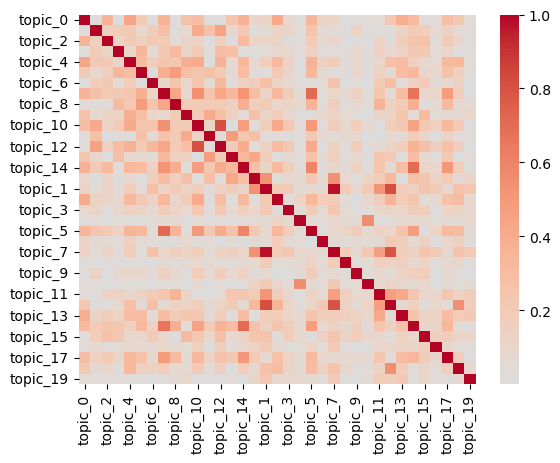

In [13]:
latentrna = rnadata.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14']]
latentatac=atacdata.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 
'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19']]

df_combined = pd.concat([latentrna,latentatac], axis=1)
correlation_matrix = df_combined.corr()
correlation_matrix = np.abs(correlation_matrix)

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", center=0.0)


(array([0]), [Text(0, 0, 'mira')])

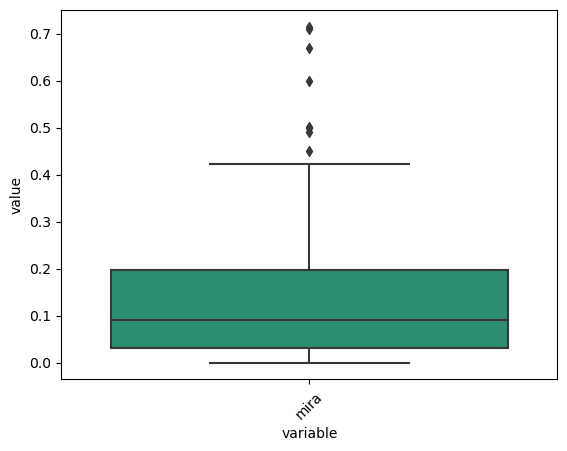

In [14]:
correlation_matrix = np.abs(correlation_matrix)

sub_corr = correlation_matrix.iloc[np.arange(0,15), np.arange(15, 35)]
df = pd.DataFrame({"variable": "mira", "value": sub_corr.to_numpy().flatten()})
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")
plt.xticks(rotation=45)


In [15]:
df.to_csv("figs/correlation_benchmark/ssc_corr_mira.csv")

### SCMVP

In [10]:
adata_mvi = sc.read_h5ad("data/datasets/neurips_data_latent.h5ad")
adata_mvi


AnnData object with n_obs × n_vars = 10862 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'DonorNumber_colors', 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'neighbors', 'organism', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_scMVP', 'X_umap', '_scvi_extra_categorical_covs', 'halo_latent_atac', 'halo_latent_ex

In [11]:
batch = adata_mvi.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
batchlist= adata_mvi.obs["batch"].map(label, na_action='ignore').to_numpy()

latent = adata_mvi.obsm["X_scMVP"]

In [13]:
latent.shape

(10862, 10)

In [4]:
scib.metrics.graph_connectivity(adata_mvi, "cell_type")

0.9965611776352075

In [6]:
scib.metrics.silhouette_batch(adata_mvi, "batch",  "cell_type","X_scMVP")


mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.902275
HSC                      0.829391
MK/E prog                0.846907
Normoblast               0.896342
Proerythroblast          0.885564


0.8720959315802862

In [8]:
from complementary_models import dHSIC
dHSIC(latent, batchlist)

0.015890605280506846

(array([0]), [Text(0, 0, 'scMVP')])

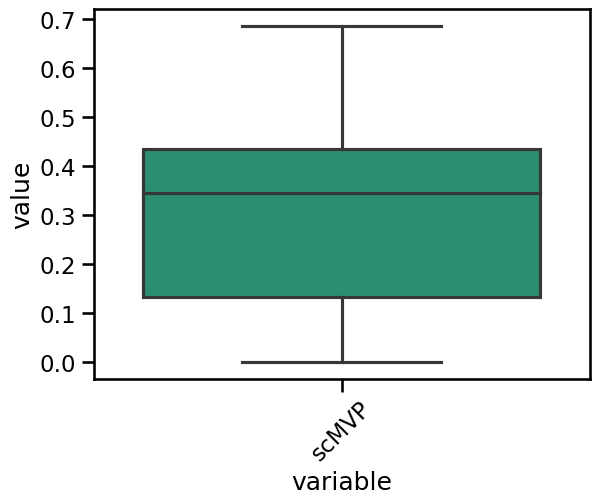

In [14]:
df_combined = pd.DataFrame(latent)
correlation_matrix = df_combined.corr()
correlation_matrix = np.abs(correlation_matrix)
lower_triangular_matrix = np.tril(correlation_matrix, k=-1)
lower_diagonal_values = lower_triangular_matrix[lower_triangular_matrix != 0]
df = pd.DataFrame({"variable": "scMVP", "value": lower_diagonal_values})
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")
plt.xticks(rotation=45)

In [15]:
df.to_csv("figs/correlation_benchmark/Neurips_corr_scMVP.csv")

## MIRA models

In [16]:
rnadata = sc.read_h5ad("data/datasets/neurips_rna_MIRA.h5ad")

In [34]:
rnadata = sc.read_h5ad("data/datasets/neurips_rna_MIRA.h5ad")
batch = rnadata.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
batchlist= rnadata.obs["batch"].map(label, na_action='ignore').to_numpy()
latent = rnadata.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12']].to_numpy()
rnadata.obsm["latent"] = latent

In [19]:
atacdata

AnnData object with n_obs × n_vars = 10862 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18'
    var: 'feature_types', 'gene_id', 'endogenous_peaks'
    uns: 'batch_colors', 'cell_type_colors', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activa

In [24]:
atacdata = sc.read_h5ad("data/datasets/neurips_atac_MIRA.h5ad")
atac_latent = atacdata.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18']]
rna_latent = rnadata.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12']]


(array([0]), [Text(0, 0, 'mira')])

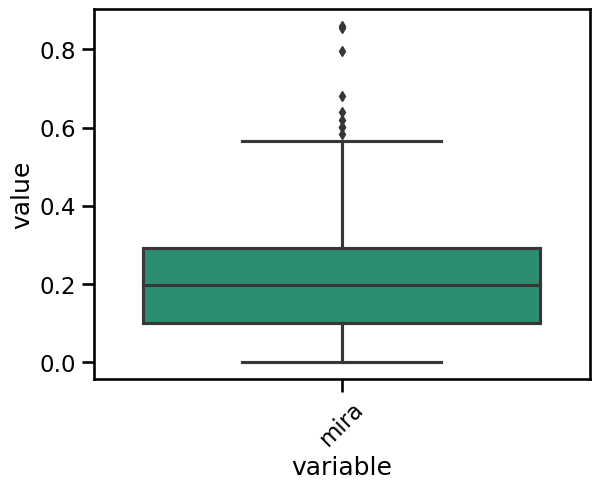

In [26]:
df_combined = pd.concat([atac_latent,rna_latent], axis=1)
correlation_matrix = df_combined.corr()
correlation_matrix = np.abs(correlation_matrix)
# lower_triangular_matrix = np.tril(correlation_matrix, k=-1)
# lower_diagonal_values = lower_triangular_matrix[lower_triangular_matrix != 0]
sub_corr = correlation_matrix.iloc[np.arange(0,18), np.arange(18, 30)]
df = pd.DataFrame({"variable": "mira", "value": sub_corr.to_numpy().flatten()})
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")
plt.xticks(rotation=45)


In [27]:
df.to_csv("figs/correlation_benchmark/Neurips_corr_mira.csv")

In [35]:
dHSIC(latent, batchlist)

0.00440480437061974

In [16]:
scib.metrics.silhouette_batch(rnadata, "batch",  "cell_type","latent")


mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.890085
HSC                      0.777119
MK/E prog                0.850301
Normoblast               0.863019
Proerythroblast          0.829997


0.8421044992537963

In [ ]:
dHSIC(latent, batchlist)

In [32]:
atacdata = sc.read_h5ad("data/datasets/neurips_atac_MIRA.h5ad")
latent = atacdata.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18']].to_numpy()
atacdata.obsm["latent"] = latent
batch = atacdata.obs["batch"].to_numpy()
label = dict(zip(np.unique(batch), range(len(np.unique(batch)))))
batchlist= atacdata.obs["batch"].map(label, na_action='ignore').to_numpy()
atacdata

AnnData object with n_obs × n_vars = 10862 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', '_scvi_batch', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18'
    var: 'feature_types', 'gene_id', 'endogenous_peaks'
    uns: 'batch_colors', 'cell_type_colors', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap', 'X_umap_features', 'latent'
    varm: 'topic_feat

In [31]:
batchlist.shape

(10862,)

In [30]:
latent.shape

(10862, 19)

In [23]:
scib.metrics.silhouette_batch(atacdata, "batch", "cell_type","latent")


mean silhouette per group:                  silhouette_score
group                            
Erythroblast             0.876583
HSC                      0.773768
MK/E prog                0.858760
Normoblast               0.837865
Proerythroblast          0.877437


0.8448826809585723

In [25]:
scib.metrics.graph_connectivity(rnadata, "cell_type")

0.982721006793437

In [33]:
dHSIC(latent, batchlist)

0.005280396226820657

In [2]:
import pandas as pd


pd1 = pd.read_csv("figs/correlation_benchmark/neurips_corr_halo.csv",index_col=0)
pd2 =  pd.read_csv("figs/correlation_benchmark/neurips_corr_GLUE.csv",index_col=0)
pd3 =  pd.read_csv("figs/correlation_benchmark/neurips_corr_mira.csv",index_col=0)
pd4 =  pd.read_csv("figs/correlation_benchmark/neurips_corr_multiVI.csv",index_col=0)
pd5 =  pd.read_csv("figs/correlation_benchmark/neurips_corr_scMVP.csv",index_col=0)
df = pd.concat([pd1, pd4, pd2, pd5, pd3], axis=0)



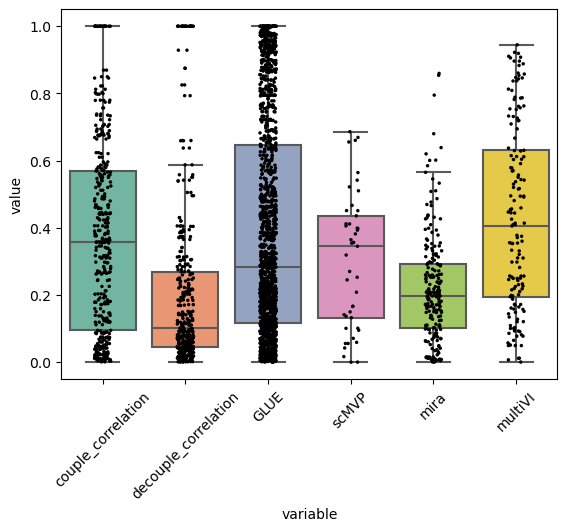

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


order = ["couple_correlation", "decouple_correlation", "GLUE", "scMVP", "mira", "multiVI"]
ax = sns.boxplot(x='variable', y='value', data=df, palette="Set2",  flierprops=dict(marker=' ', color='white', markersize=2), order=order)
sns.stripplot(x='variable', y='value', data=df, color='black', size=2.5, jitter=True, order=order)
plt.xticks(rotation=45)
ax.set_xticklabels(order)
plt.savefig("Benchmark/corr_neurips.pdf", dpi=300)
plt.show()


In [5]:
df.to_csv("Benchmark/neurips_corr.csv")